In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

# load the data from the Thinkful PostgreSql database using our credentials.

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
temperature_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

Tasks:

Build a regression model where the target variable is temperature. 

As explanatory variables, use humidity, windspeed, windbearing, and pressure.

 Estimate the model using OLS.

Now, check if your model meets the Gauss-Markov Conditions above.

If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [44]:
temperature_df.head()

temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


- Build a regression model where the target variable is temperature.

- As explanatory variables, use humidity, windspeed, windbearing, and pressure.

In [45]:
# define features with variable X as dataframe
X = temperature_df[['humidity','windspeed', 'windbearing', 'pressure']]

# define target variable y as series
y = temperature_df['temperature']

# this is our equation: Y = 1 + 2*X + 3*X^2
# temperature_df['y_eq'] = 1 +2*X+ 3*(X**2)

 # instantiate Linear Regression Model
lr = linear_model.LinearRegression()

# fit model, find coefficients 
lr.fit(X, y)

predictions = lr.predict(X)
errors = np.array(y) - lr_predictions

# print coefficients
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)




Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528538


- Estimate the model using OLS

- Now, check if your model meets the Gauss-Markov Conditions above.

    - If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Gauss Markov assumptions (also called conditions):

- linearity of models in their coefficients
- the error term should be zero on average
- homoscedasticity
- low multicollinearity
- error terms should be uncorrelated with one another
- features shouldn't be correlated with the errors
normality of the errors

So...

The Gauss Markov theorem tells us that if a certain set of assumptions are met, **the ordinary least squares estimate for regression coefficients gives you the best linear unbiased estimate (BLUE) possible.** [Source](https://www.statisticshowto.datasciencecentral.com/gauss-markov-theorem-assumptions/)

See below, our errors are a very small number; making them near zero.  Thus, satisfying Exogeneity

In [104]:
print(" The Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

 The Mean of the errors in the medical costs model is: -4.714704061941714e-16


Plotting our predictions versus our errors, we see that our data are very heterscedastic (there's a pattern).  So our assumption of homoscedasticity is not met. 

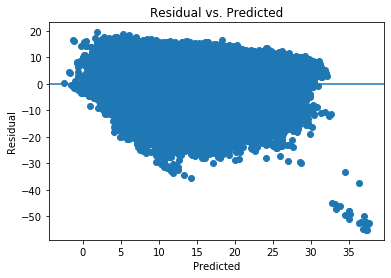

In [105]:

plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

To confirm our observations, let's perform two statistical tests to determine if we reject our null hypothesis which is that the errors are homoscedastic. We will use the Bartlett and Levene tests from scipy.

In [106]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

z = 0.05
x = bart_stats[1]
y = lev_stats[1]
one = z < x
two = z < y
if one | two == False: print("reject the null!")
if one | two == True: print("Don't reject the null!"); 
# thumbs up for statement code tho ;)

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0
reject the null!


Since both p-values from the statistical tests are below our threshold, we cannot meet the assumption of homoscedasticity, and thus, our parameter's accuracies are not reliable!

Next, let's check the assumption of low multicollinearity via a correlation matrix.

In [107]:
X.corr()

,const,humidity,windspeed,windbearing,pressure
const,NaN,NaN,NaN,NaN,NaN
humidity,NaN,1.000000,-0.224951,0.000735,0.005454
windspeed,NaN,-0.224951,1.000000,0.103822,-0.049263
windbearing,NaN,0.000735,0.103822,1.000000,-0.011651
pressure,NaN,0.005454,-0.049263,-0.011651,1.000000


Of course, since we have few features in this model, we can also visualize this in a heatmap!

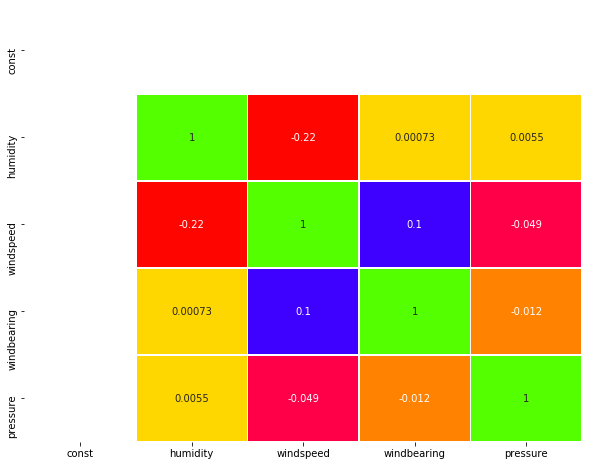

In [108]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, 
            vmin=-1, 
            vmax=1, 
            cmap='prism', linewidths=0.5, cbar=False); #just wanna experiment with cmap!

Since the highest linear relationship exits between hummidity and windspeed, at -0.22, we confirm the assumption of low multicollinearity is met.

Next, let's confirm that the errors are uncorrelated with one another--

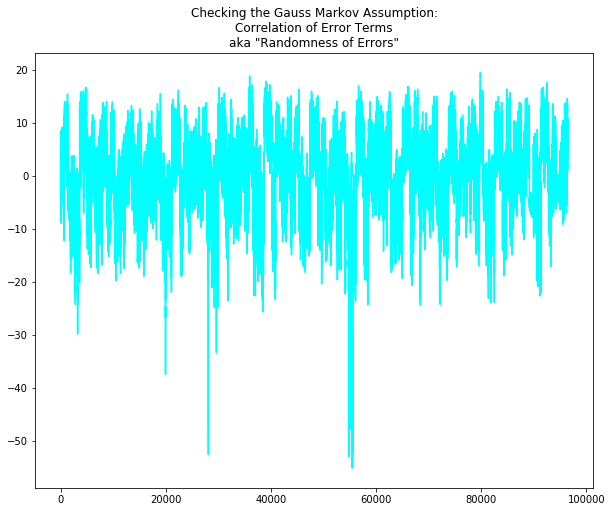

In [109]:
plt.figure(figsize=(10,8))
plt.plot(errors, color='cyan') # I just like the color cyan...
plt.title('Checking the Gauss Markov Assumption:\nCorrelation of Error Terms\naka "Randomness of Errors"')
plt.show()


Cool, we can confirm that the errors are random!  We can also check this using the statsmodel function: _autocorrelation function_

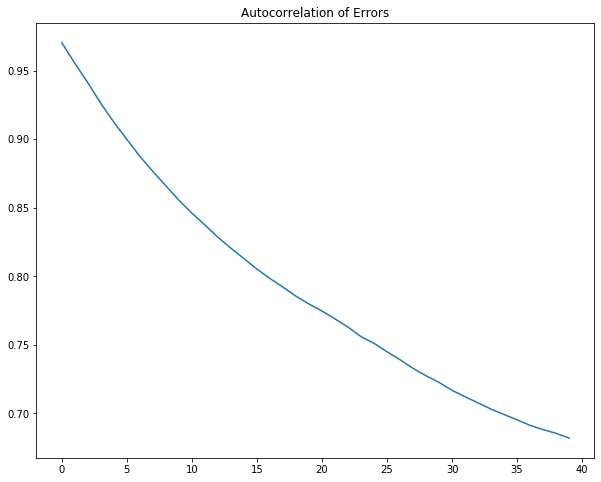

In [110]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.figure(figsize=(10,8))
plt.plot(acf_data[1:])
plt.title('Autocorrelation of Errors')
plt.show()

Whoa! We see that our errors assume some type of pattern; since we are attempting to confirm that the errors aren't predicting one another, this plot indeed shows that they are related in some way.  In fact, we are seeing a positive serial correlation.  Remember, one of our features, _weather_ is time-series correlated! When we rejected our null hypothesis for this assumption (that the error terms are uncorrelated), we then move to the alternate hypothesis which states that there's a positive serial correlation between the errors.  How cool!

Why is this bad?  _Analyst Forum_ says:

- Linear regression is an incorrect estimate of the regression coefficient standard errors.
- When one of the independent variables is a lagged value of the dependent variable, then serial correlation causes all the parameter estimates to be inconsistent and invalid. Otherwise, serial correlation does not affect the consistency of the estimated regression coefficients.
- Serial correlation leads to wrong inferences.

In case of positive serial correlation:
- Standard errors are underestimated
- T-statistics are inflated
- Type-I error increases

[Source](https://www.analystforum.com/article/cfa/serial-correlation)

Final assumption check: Features shouldn't be correlated with errors

In [111]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

,error
const,NaN
humidity,-1.935763e-16
windspeed,-3.912914e-17
windbearing,-2.293671e-16
pressure,-7.998021e-16
error,1.000000e+00


Again, our correlation matrix tells us that the correlation between features and errors are very low. 

#Normality of the error terms (for the guild)

_normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed_

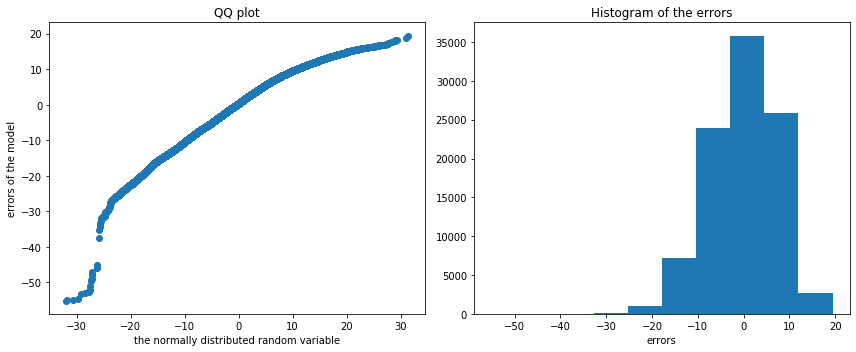

In [112]:
# informal way

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()


_the QQ plot and the histogram imply that the distribution is not very far away from normal._

the statistical tests used to find out whether or not error terms are normal are the Jarque Bera and Normaltest from scipy

In [113]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

# let's use the leet code from before--
z = 0.05
x = jb_stats[1]
y = norm_stats[1]
one = z < x
two = z < y
if one | two == False: print("The errors are NOT normally distributed!")
if one | two == True: print("The errors ARE normally distributed!"); 
# thumbs up for statement code tho ;)

Jarque-Bera test statistics is 3793.296735252357 and p value is 0.0
Normality test statistics is 3375.4323076995743 and p value is 0.0
The errors are NOT normally distributed!
